## 量子回路学習

まず、必要なライブラリを最初にインポートします。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.algorithms.optimizers import SPSA, COBYLA
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

## 初歩的な例
ある入力$\{x_i\}$と、既知の関数$f$による出力$y_i=f(x_i)$が学習データとして与えられた時に、そのデータから関数$f$を近似的に求める問題を考えてみます。例として、$f(x)=x^3$としてみます。

### 学習データの準備

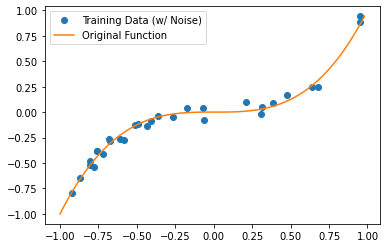

In [2]:
random_seed = 0
np.random.seed(random_seed)

# Qubit数、回路の深さ、訓練サンプル数の定義など
nqubit = 3
c_depth = 5
x_min = -1.; x_max = 1.; num_x_train = 30

# パラメータ数の設定
num_vars = nqubit*3*(c_depth+1)
params = np.random.rand(num_vars)*2*np.pi

# 関数の定義
func_to_learn = lambda x: x**3
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 関数に正規分布ノイズを付加
mag_noise = 0.05
y_train_noise = y_train + mag_noise * np.random.randn(num_x_train)

x_list = np.arange(x_min, x_max, 0.02)
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.legend()

### 量子状態の生成

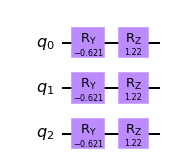

In [3]:
def U_in(x, nqubit):
    qr = QuantumRegister(nqubit, name='q')
    U = QuantumCircuit(qr)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.ry(angle_y, i)
        U.rz(angle_z, i)

    U.name = "U_in"
    return U

U_in(x_train[0], nqubit).draw('mpl')

### 変分フォームを使った状態変換

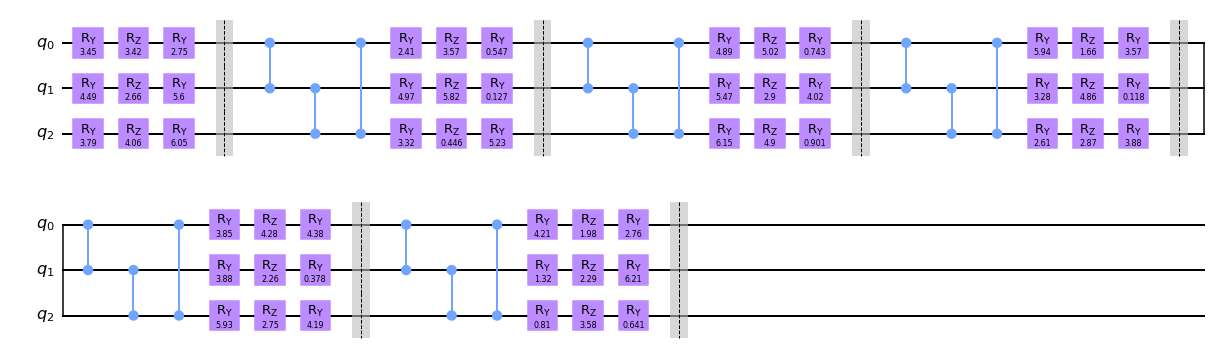

In [4]:
def U_out(nqubit, params):
    qr = QuantumRegister(nqubit, name='q')
    #cr = ClassicalRegister(nqubit)
    U = QuantumCircuit(qr)

    for i in range(nqubit):
        U.ry(params[i], i)
        U.rz(params[nqubit+i], i)
        U.ry(params[nqubit*2+i], i)
    U.barrier()
    for d in range(c_depth):
        for j in range(nqubit-1):
            U.cz(j, j+1)
        U.cz(nqubit-1, 0)
        for i in range(nqubit):
            U.ry(params[nqubit*(3*d+3)+i], i)
            U.rz(params[nqubit*(3*d+4)+i], i)
            U.ry(params[nqubit*(3*d+5)+i], i)
        U.barrier()
    U.name = "U_out"
    return U

U_out(nqubit, params).draw('mpl')

### 測定とモデル出力

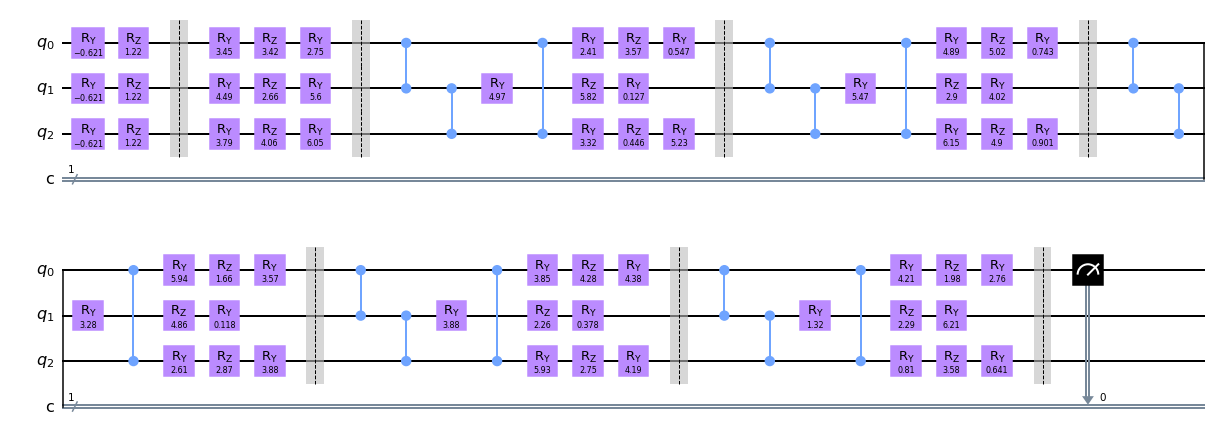

In [5]:
def pred_circ(x, nqubit, params):

    qr = QuantumRegister(nqubit, name='q')
    cr = ClassicalRegister(1, name='c')
    circ = QuantumCircuit(qr, cr)

    u_in = U_in(x, nqubit).to_instruction()
    u_out = U_out(nqubit, params).to_instruction()

    circ.append(u_in, qr)
    circ.barrier()
    circ.append(u_out, qr)
    circ.measure(0, 0)

    return circ

pred_circ(x_train[0], nqubit, params).decompose().draw('mpl')

In [6]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 8192

def objective_function(params):
    cost_total = 0
    for i in range(len(x_train)):
        qc = pred_circ(x_train[i], nqubit, params)
        qc = transpile(qc, backend=backend)
        result = backend.run(qc, shots=NUM_SHOTS).result()
        counts = result.get_counts(qc)
        exp_2Z = (2*counts['0']-2*counts['1'])/NUM_SHOTS
        cost = (y_train_noise[i] - exp_2Z)**2
        cost_total += cost

    return cost_total

ret[0] = [3.4665162  5.5012226  3.78891674 4.42967061 2.53094787 4.27003762
 2.65250137 5.37760898 6.04765016 2.57126599 4.99315938 3.33984918
 3.59074379 5.83142428 0.31696827 0.7657895  0.09342967 5.19526121
 4.92801929 5.20428425 6.25619108 5.15746478 3.08662921 4.86524828
 1.7068861  4.01929492 1.38211471 5.93168317 3.2774166  2.60274779
 1.65293246 4.86239125 2.86605843 4.57165983 0.09779675 3.69128228
 3.83160182 3.85183029 5.91110338 4.28222999 2.25629258 2.73423111
 4.36885383 0.35720303 4.15335516 4.21103845 1.32185768 0.80989606
 1.98169927 2.28513691 3.58254558 2.753353   6.20998834 0.64103857]


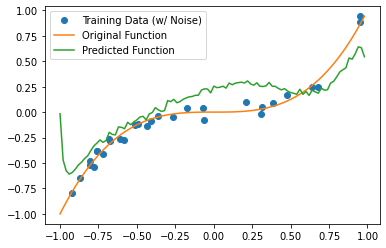

In [7]:
optimizer = COBYLA(maxiter=100, tol=0.05)
ret = optimizer.optimize(num_vars=num_vars, objective_function=objective_function, initial_point=params)

# 最適化したパラメータをプリントアウト
print('ret[0] =',ret[0])

x_list = np.arange(x_min, x_max, 0.02)
y_pred = []
for x in x_list:
    qc = pred_circ(x, nqubit, ret[0])
    qc = transpile(qc, backend=backend)
    result = backend.run(qc, shots=NUM_SHOTS).result()
    counts = result.get_counts(qc)
    exp_2Z = (2*counts['0']-2*counts['1'])/NUM_SHOTS
    y_pred.append(exp_2Z)

# 結果を図示する
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.plot(x_list, np.array(y_pred), label='Predicted Function')
plt.legend();

## 素粒子現象の探索への応用

### 学習データの準備

In [8]:
# ファイルから変数を読み出す
df = pd.read_csv("data/SUSY_1K.csv",
                 names=('isSignal','lep1_pt','lep1_eta','lep1_phi','lep2_pt','lep2_eta',
                        'lep2_phi','miss_ene','miss_phi','MET_rel','axial_MET','M_R','M_TR_2',
                        'R','MT2','S_R','M_Delta_R','dPhi_r_b','cos_theta_r1'))

# 学習に使う変数の数
feature_dim = 3  # dimension of each data point

# 3, 5, 7変数の場合に使う変数のセット
if feature_dim == 3:
    SelectedFeatures = ['lep1_pt', 'lep2_pt', 'miss_ene']
elif feature_dim == 5:
    SelectedFeatures = ['lep1_pt','lep2_pt','miss_ene','M_TR_2','M_Delta_R']
elif feature_dim == 7:
    SelectedFeatures = ['lep1_pt','lep1_eta','lep2_pt','lep2_eta','miss_ene','M_TR_2','M_Delta_R']

# 学習に使う事象数: trainingは訓練用サンプル、testingはテスト用サンプル
train_size = 20
test_size = 20

# オプティマイザーをCallする回数の上限
niter = 300
random_seed = 10598

df_sig = df.loc[df.isSignal==1, SelectedFeatures]
df_bkg = df.loc[df.isSignal==0, SelectedFeatures]

# サンプルの生成
df_sig_train = df_sig.values[:train_size]
df_bkg_train = df_bkg.values[:train_size]
df_sig_test = df_sig.values[train_size:train_size+test_size]
df_bkg_test = df_bkg.values[train_size:train_size+test_size]
train_data = np.concatenate([df_sig_train,df_bkg_train])
test_data = np.concatenate([df_sig_test,df_bkg_test])
#print('train_data =',training_data)
#print('test_data =',test_data)
train_label = np.concatenate([np.ones((train_size),dtype=int),np.zeros((train_size),dtype=int)])
test_label = np.concatenate([np.ones((test_size),dtype=int),np.zeros((test_size),dtype=int)])

train_label_one_hot = np.zeros((train_size*2, 2))
for i in range(train_size*2):
    train_label_one_hot[i, train_label[i]] = 1
test_label_one_hot = np.zeros((test_size*2, 2))
for i in range(test_size*2):
    test_label_one_hot[i, test_label[i]] = 1

#datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
#datapoints_tr, class_to_label_tr = split_dataset_to_data_and_labels(training_input)

mms = MinMaxScaler((-1, 1))
norm_train_data = mms.fit_transform(train_data)
norm_test_data = mms.transform(test_data)

### 量子状態の生成

In [9]:
#feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=1)
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='circular')

### 変分フォームを使った状態変換

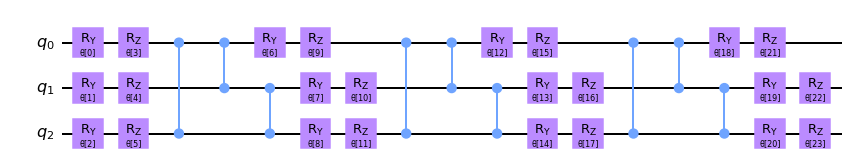

In [10]:
ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry','rz'], entanglement_blocks='cz', entanglement='circular', reps=3)
#ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry'], entanglement_blocks='cz', entanglement='circular', reps=3)
ansatz.decompose().draw('mpl')

### 測定とモデル出力

In [11]:
# シミュレータで実行する場合
backend = Aer.get_backend('qasm_simulator')

# 量子コンピュータで実行する場合
#from qiskit import IBMQ
#IBMQ.enable_account('__your_token__')
#provider0 = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#backend_name = 'ibmq_santiago'
#backend = provider0.get_backend(backend_name)

optimizer = COBYLA(maxiter=niter, disp=True)

quantum_instance = QuantumInstance(backend=backend,
                                   shots=4096,
                                   seed_simulator=random_seed,
                                   seed_transpiler=random_seed,
                                   skip_qobj_validation=True)

objective_func_vals = []
# Draw the value of objective function every time when the fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    #print('obj_func_eval =',obj_func_eval)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### シミュレーションで実行

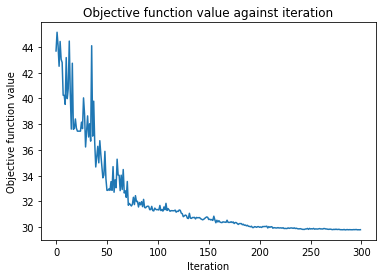



   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  300   F = 2.979319E+01    MAXCV = 0.000000E+00
   X =-5.867493E-01   5.942180E-01   2.077082E+00   1.768845E+00   6.446642E-01
       7.956704E-01   2.227171E+00   1.684657E+00   5.529724E-01   9.892648E-01
       1.303028E+00   3.681129E-01   1.392656E-01   7.392375E-01   1.538539E+00
      -3.929783E-01   1.609135E+00  -8.001690E-02   1.634638E+00   9.375436E-01
       1.248396E+00   1.202907E-01   3.214125E-01   4.824567E-01
--- Classification Train score: 80.0% ---
--- Classification Test score:  42.5% ---


In [12]:
vqc = VQC(num_qubits=feature_dim,
          feature_map=feature_map,
          ansatz=ansatz,
          loss="cross_entropy",
          optimizer=optimizer,
          quantum_instance=quantum_instance,
          callback=callback_graph)
vqc.fit(norm_train_data, train_label_one_hot)

print('')
train_score = vqc.score(norm_train_data, train_label_one_hot)
test_score = vqc.score(norm_test_data, test_label_one_hot)
print(f'--- Classification Train score: {train_score*100}% ---')
print(f'--- Classification Test score:  {test_score*100}% ---')